> https://docs.langchain.com/oss/python/langgraph/use-time-travel

**Build the graph**

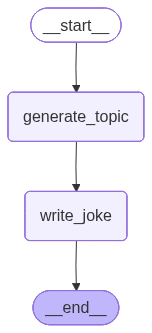

In [1]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain_deepseek import ChatDeepSeek
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]


model = ChatDeepSeek(model="deepseek-chat", temperature=0)


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = model.invoke("Give me one and only one funny topic for a joke.")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

**Run the graph**

In [14]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

A penguin trying to use a vending machine.

A penguin waddles up to a vending machine and stares at the snacks. He puts in his coins, makes his selection, and a bag of pretzels gets stuck.

He squawks in frustration, waddles back, and gives the machine a solid whack with his flipper. Nothing happens.

He sighs, turns to the human waiting behind him, and says, "My usual technique is useless. This calls for a different approach."

He then just slides down the front of the machine on his belly.


**Identify a checkpoint**

In [15]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

In [16]:
for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0bae06-e97a-6b7a-8002-eb791b2a1e0d

('write_joke',)
1f0bae06-adbc-6e30-8001-c2efcf6d5319

('generate_topic',)
1f0bae06-9d9c-6ef6-8000-70154dcca488

('__start__',)
1f0bae06-9d98-6b94-bfff-84ecccef1a09



In [17]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'A penguin trying to use a vending machine.'}


**Update the state**

In [18]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
new_config

{'configurable': {'thread_id': '26ac70d3-f262-4bdb-8bd4-7e4dd357b292',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bae07-5885-6a4c-8002-343d126f679b'}}

In [19]:
selected_state.config

{'configurable': {'thread_id': '26ac70d3-f262-4bdb-8bd4-7e4dd357b292',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bae06-adbc-6e30-8001-c2efcf6d5319'}}

**Resume execution from the checkpoint**

In [20]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'A penguin waddles up to a vending machine and stares at the snacks. He puts in his coins, makes his selection, and a bag of pretzels gets stuck.\n\nHe squawks in frustration, waddles back, and gives the machine a solid whack with his flipper. Nothing happens.\n\nHe sighs, turns to the human waiting behind him, and says, "My usual technique is useless. This calls for a different approach."\n\nHe then just slides down the front of the machine on his belly.'}